<CENTER>
    <a href="http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html" class="icons"><img src="./images/ATLASOD.gif" style="width:40%"></a>
</CENTER>

<CENTER><h1>Searching for the Higgs boson </h1></CENTER>


Below are some Feyman diagrams of ways the Higgs boson can be produced according to the Standard Model:

<br>

<CENTER><img src="https://cds.cern.ch/record/2243593/files/Figures_FeynmanHprod.png" style="width:50%"></CENTER>

Just as the Higgs can be produced in several ways, the Higgs can also decay in a number of ways or 'channels'. In this excercise, we will be searching for the Higgs in two different decay channels.

---

### Warning:


Some of the datafiles used in this notebook have millions of events - Don't be surpised if running some of the event loops takes up to 10 mins!

---

<CENTER><h2>Search 1: The H&#8594;&gamma;&gamma; channel</h2></CENTER>

<CENTER><img src="./images/higgsFD.png" style="width:30%"></CENTER>

<br>
  
One of the ways the Higgs can decay is to two photons. We call this channel __H&#8594;&gamma;&gamma;__ ("Higgs to gamma gamma").


Of course, there are other ways two photons can be made in the LHC, but if we look at the entire range of invariant masses of these two photons, we should expect there to be more of them around 125 GeV, the mass of the Higgs ("bump hunting").

#### Importing the usual libraries

In [2]:
import ROOT
from ROOT import TMath
import time
%jsroot

### 1. Reading in ROOT files
<br>
In the usual way:

1. Open our datafile containing two photon ("diphoton" or $\gamma\gamma$) events 

2. Retrieive the TTree storing the data and 

3. Get the tree entries 

<br>

As always, if you need hints, refer back to the first tutorial `HistogramTutorial`. If you are really stuck, check out the solutions notebook `HiggsSearch_Solutions`

#### a) Open Root File

Using `ROOT`, `TFile.Open()` a sample of diphoton data, stored at 

`https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root`

 

In [44]:
#f = ####

#To solution:
f = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root")

#### b) Retrieve TTree

`Get()` the TTree named `mini` from the ROOT file `f`

In [45]:
#tree = ####

#To solution:
tree = f.Get("mini")

#### c) Load TTree data

`GetEntries()` of our `tree` to load in the data for each event stored in the tree

In [46]:
####

#To solution:
tree.GetEntries()

430344

### 2. Preparing histograms
<br>

As in previous examples, before we are ready to fill our histograms we need to:

1. Create a canvas for the histogram to be drawn onto

2. Define the settings of the histograms we intend to draw

#### a) Create canvas

Using `ROOT`, create a `TCanvas` named `"Canvas"` with the title `'cz'` that's sized `800`x`600` pixels

In [47]:
#canvas = ####

#To solution
canvas = ROOT.TCanvas("Canvas","cz",800,600)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


#### b) Set up histogram 

Set up a `TH1F` type histogram to be filled with our __diphoton invariant masses__. Name it `h_M_Hyy`, give it the title `Diphoton invariant-mass`, label the x and y axes `Invariant Mass m_{yy} [GeV]` and `events` respectively and divide it in `30` bins between `105` and `160` GeV.

__Hint:__ Remember how we separate names, titles and axis labels in the `TH1F` function?

In [48]:
#Invariant mass histograms definition
#hist = ####

#To solution
hist = ROOT.TH1F("h_M_Hyy","Diphoton invariant-mass ; Invariant Mass m_{yy} [GeV] ; events",30,105,160)

### 3. Selecting events and filling histograms

Our strategy for filling our diphoton invariant mass histogram is as follows:

1. Loop through each `event` in our `tree`. We can print out how many events have been processed every 100000 events to keep track of progress.

2. In each event, search for _'good quality photons'_ (more on this later).

3. If there are exactly two qood quality photons, check that they are _'well isolated'_ (again, more later).

4. If the two photons are well-isolated, extract their 4 momentum from the components' individual TTree branches, converting their transverse momentum (pT) and energy (E) from MeV, as is stored in the TTree, to GeV as will be displayed in the histogram.

5. Add the TLorentz vectors of the two photons together

6. Fill the histogram with the invariant mass of our two-photon system

__NOTE:__ To simplify our code, we will be writing some custom __functions__ to handle some of the more complicated
operations performed in each event

#### a) Loop tracker

In [2]:
def trackProgress(n,m):
    """
    Function which prints the event loop progress every m events 
    
    Parameters
    ----------
    n : Number of events processed so far
    
    m : Printout event interval
    
    """
    if n == 0:
        print("Event loop tracker")
        print("------------------")
    
    if(n%m==0):
        print("%d events processed" % n)

#### b) Photon quality

In [50]:
#@NOTE: Explain 'triggers'

def locateGoodPhotons(tree):
    """
    Function which returns the index of photons in the event which pass our quality requirements.
    These are:
        - Event passes photon trigger
        - Photon is identified as such, passing 'Tight' requirements
        - Photon has pT > 25 GeV (or 25000 MeV)
        - Photon is in the 'central' region of ATLAS i.e. |eta| < 2.37
        - Photon does not fall in the 'transition region' between ATLAS's inner detector barrell
          and ECal encap i.e. 1.37 <= |eta| <= 1.52
          
    Parameters
    ----------
    tree : TTree entry for this event
    
    """
    
    ## Checking the event passes the photon trigger
    if(tree.trigP):
        
        #Initialise (set up) the variables we want to return
        goodphoton_index = [] #Indices (position in list of event's photons) of our good photons
            
        ##Loop through all the photons in the event
        for j in range(0,tree.photon_n):
            
            ##Check photon ID
            if(tree.photon_isTightID[j]):
                
                if(tree.photon_pt[j] > 25000 and  #Check photon has a large enough pT
                  (TMath.Abs(tree.photon_eta[j]) < 2.37) and  #Check photon eta is in the 'central' region
                  
                  #Exclude "transition region" between ID barrell and ECal endcap
                  (TMath.Abs(tree.photon_eta[j]) < 1.37 or TMath.Abs(tree.photon_eta[j]) > 1.52)):

                    goodphoton_index.append(j) #Store photon's index
                    
        return goodphoton_index #return list of good photon indices

#### c) Photon isolation

In [40]:
def photonIsolation(tree,photon_indices):
    """
    Function which returns True if all photons are well-isolated, otherwise returns false.
    
    A photon is considered 'isolated' if the transverse momentum and transverse energy within 
    a particular radius of the photon is below a certain threshold compared to the photon's 
    transverse momentum (don't worry too much about the details!).
    
    Parameters
    ----------
    tree : TTree entry for this event
    
    photon_indices : List containing the indices in the TTree of our photons of interest
    
    """
    
    #Loop through our list of photon indices
    for i in photon_indices:
        
        #If each photon passes isolation requirements...
        if((tree.photon_ptcone30[i]/tree.photon_pt[i] < 0.065) and 
           (tree.photon_etcone20[i] / tree.photon_pt[i] < 0.065)):
            continue #...keep the loop going 
        
        #If any fail, break the loop and return False
        else: 
            return False
    
    #If the loop is able to finish, i.e. all photons are well-isolated, return True
    return True

#### d) Extracting four-momentum

In [52]:
def photonFourMomentum(tree, photon_indices):
    """
    Function which returns the 4 momenta of a list of photons in an event as a list of TLorentzVectors
    
    Parameters
    ----------
    tree : TTree entry for this event
    
    photon_indices : List containing the indices in the TTree of our photons of interest
    
    """
    
    photon_four_momenta = []
    
    #Loop through our list of photon indices
    for i in photon_indices:
    
        #Initialse (set up) an empty 4 vector for each photon
        Photon_i = ROOT.TLorentzVector()
        
        #Retrieve the photon's 4 momentum components from the tree
        #Convert from MeV to GeV where needed
        Photon_i.SetPtEtaPhiE(tree.photon_pt[i]/1000., tree.photon_eta[i],tree.photon_phi[i],tree.photon_E[i]/1000.)
        
        #Store photon's 4 momentum
        photon_four_momenta.append(Photon_i)
        
        
    return photon_four_momenta

#### e) Sum the 4 momenta of each photon in the event

In [53]:
def sumFourMomentum(four_momenta):
    """
    Function which sums a list of four-momenta, and returns the resultant four-momentum of the system
    
    Parameters
    ----------
    four_momenta : List of TLorentzVectors containing the four-momentum of each object in the system
    
    """
    
    # Initialise (set up) TLorentzVector for our momentum sum
    four_mom_sum = ROOT.TLorentzVector()
    
    for obj in four_momenta:
        four_mom_sum += obj
        
    return four_mom_sum

### Putting it all together!

In [54]:
n = 0
for event in tree:
    
    #a) Loop progress tracking: Print progress every 100,000 events
    trackProgress(n,100000)
    n += 1
    
    #b) Identify exactly two 'good quality photons'
    goodphoton_indices = locateGoodPhotons(tree)
    
    if len(goodphoton_indices) == 2:
        
        #c) Check our good quality photons are well-isolated
        photons_are_isolated = photonIsolation(tree,goodphoton_indices)
        
        if photons_are_isolated:
        
            #d) Convert 4-momentum from MeV to GeV
            photon_four_momenta = photonFourMomentum(tree, goodphoton_indices)
            
            #e) Add the 4-momenta together
            Photon_12 = sumFourMomentum(photon_four_momenta)
            
            #f) Fill the histogram with the diphoton invariant mass
            inv_mass = Photon_12.M() #Calculated invariant mass
            
            hist.Fill(inv_mass) #Fill histogram with invariant mass

100000 events processed
200000 events processed
300000 events processed
400000 events processed


### 4. Draw plots

Finally, we would like to draw our diphoton invariant mass histograms and display the canvas showing our results. 

For this study, we would also like to plot the __error bars__ for each bin to illustrate the (statistical) __uncertainties__ on our measurement. This is done by passing `"E"` as an argument to `Draw()` when drawing the _histogram_.

In [55]:
#hist.####
#canvas.####

#To solution
hist.Draw("E")
canvas.Draw()

To make our plot easier to read, we can change the y axis from a __linear scale__ to a __log scale__. This is done by calling the `.SetLogY()` function on our `canvas`, then `Draw()`ing it agin

In [69]:
#hist.Draw("E")
#hist.SetMinimum(10)
canvas.SetLogy()
canvas.Draw()

### Some questions to think about...

1. Can we say we have 'found' the Higgs based on these histograms alone? Why/why not?
2. What steps could we take to make our search for the Higgs more robust?

---

<CENTER><h2>Search 2: The H&#8594;WW channel</h2></CENTER>

The following analysis will aim to find a signal for the Higgs boson decaying to 2 W-bosons:

<br>

<CENTER><img src="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/HIGG-2016-07/fig_01a.png" style="width:30%"></CENTER>

<br>

above its the largest background; Events coming from the SM WW-diboson background  production:

<CENTER><img src="https://cds.cern.ch/record/1484203/files/fig1b.png" style="width:30%"></CENTER>


<br>

This __non-resonant search__ is done by histogramming some variable of the decay products (in this case a variable called _transverse mass_) for both data and Monte-Carlo simulations of the background, subtracting the backgrounds from the data (scaled for the fact we have many more simulated events than real events) before seeing if we have any **significant** number of events left over.


**Question:** Why can a bump hunt not be performed in this channel? 

*Hint*: $m_H$=125 GeV, $m_W$=80 GeV

In [3]:
def printTreeBranches(tree):
    branches = tree.GetListOfBranches()

    print('TTree branch names:')
    print('-------------------')
    for branch in branches:
        print(branch.GetName())

In [7]:
#Dilepton data
#More luminosity is available (B-D)! Add in at some point?
data = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/Data/data_A.2lep.root")
dataTree = data.Get("mini")
print('Tree contains %d entries\n' % dataTree.GetEntries())

#Peek inside?
view_branches = True #Set to True to look inside
if view_branches: printTreeBranches(dataTree)

Tree contains 668152 entries

TTree branch names:
-------------------
runNumber
eventNumber
channelNumber
mcWeight
scaleFactor_PILEUP
scaleFactor_ELE
scaleFactor_MUON
scaleFactor_PHOTON
scaleFactor_TAU
scaleFactor_BTAG
scaleFactor_LepTRIGGER
scaleFactor_PhotonTRIGGER
trigE
trigM
trigP
lep_n
lep_truthMatched
lep_trigMatched
lep_pt
lep_eta
lep_phi
lep_E
lep_z0
lep_charge
lep_type
lep_isTightID
lep_ptcone30
lep_etcone20
lep_trackd0pvunbiased
lep_tracksigd0pvunbiased
met_et
met_phi
jet_n
jet_pt
jet_eta
jet_phi
jet_E
jet_jvt
jet_trueflav
jet_truthMatched
jet_MV2c10
photon_n
photon_truthMatched
photon_trigMatched
photon_pt
photon_eta
photon_phi
photon_E
photon_isTightID
photon_ptcone30
photon_etcone20
photon_convType
tau_n
tau_pt
tau_eta
tau_phi
tau_E
tau_isTightID
tau_truthMatched
tau_trigMatched
tau_nTracks
tau_BDTid
ditau_m
lep_pt_syst
met_et_syst
jet_pt_syst
photon_pt_syst
tau_pt_syst
XSection
SumWeights
largeRjet_n
largeRjet_pt
largeRjet_eta
largeRjet_phi
largeRjet_E
largeRjet_m
largeRj

In [8]:
## qq->WW background (MC)
bkg = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/MC/mc_363492.llvv.2lep.root")
bkgTree = bkg.Get("mini")
print('Tree contains %d entries\n' % bkgTree.GetEntries()) #Will need to be scaled to number of data events

#Peek inside?
view_branches = False #Set to True to look inside
if view_branches: printTreeBranches(bkgTree)

Tree contains 3409043 entries



In [9]:
c = ROOT.TCanvas("HWWCanvas","Higgs->WW Analysis",800,600)
h_bgs = ROOT.TH1F("h_bgs","Transverse mass mT",20,60,240)
h_dat = ROOT.TH1F("h_dat","Transverse mass mT",20,60,240)

---

In [39]:
def hWW(tree,hist):
    """
    Function which executes the analysis flow for the Higgs production cross-section measurement in the H->WW
    decay channel paper: https://arxiv.org/pdf/1808.09054.pdf
    
    Fills a histogram with mT(llvv) of events which pass the full set of cuts 
    
    Parameters
    ----------
    tree : A Ttree containing data / background information
    
    hist : The name of the histogram to be filled with mT(llvv) values
    """
    
    n = 0
    for event in tree:
        
        #############################
        ### Event-level requirements
        #############################
    
        trackProgress(n,100000)
        n += 1
        
        #if tree.trigE and tree.trigM: #... with different flavour (pass el and mu trigger)...
        #if tree.trigE or tree.trigM: #... event passes el or mu trigger...

        ###################################
        ### Individual lepton requirements
        ###################################

        if tree.lep_n == 2: #Exactly two leptons...

            if tree.lep_type[0] != tree.lep_type[1]: #... with different flavour

                if tree.lep_charge[0] != tree.lep_charge[1]: #... and opposite charge...

                    #... @to-Do with both isolated (need electron & muon isolation definitions)

                    if (tree.lep_pt[0] > 22000) and (tree.lep_pt[0] > 15000): #pT requirements
                        #Note TTrees always sort objects in descending pT order
                        
                        if abs(tree.lep_phi[0]-tree.lep_phi[1]) < 1.8: #lepton separtion in phi 
                        
                            #################################
                            ### Dilepton system requirements
                            #################################

                            #Initialse (set up) an empty 4 vector for dilepton system
                            dilep_four_mmtm = ROOT.TLorentzVector()

                            #Loop through our list of lepton indices
                            for i in range(0,tree.lep_n):

                                #Initialse (set up) an empty 4 vector for each lepton
                                lep_i = ROOT.TLorentzVector()

                                #Retrieve the lepton's 4 momentum components from the tree
                                lep_i.SetPtEtaPhiE(tree.lep_pt[i], tree.lep_eta[i],tree.lep_phi[i],tree.lep_E[i])

                                #Store lepton's 4 momentum
                                dilep_four_mmtm += lep_i

                            if (dilep_four_mmtm.M() > 10000) :#and (dilep_four_mmtm.M() < 55000):

                                #####################
                                ### MET requirements
                                #####################

                                #Initialse (set up) an empty 4 vector for the event's MET and fill from tree
                                met_four_mom = ROOT.TLorentzVector()
                                met_four_mom.SetPtEtaPhiE(tree.met_et,0,tree.met_phi,tree.met_et)
                                
                                if met_four_mom.Pt() > 20000:
                                    
                                        #####################
                                        ### Full llvv system
                                        #####################
                                        
                                        system_four_mom = dilep_four_mmtm + met_four_mom
                                        hist.Fill(system_four_mom.Mt()/1000)
                                        
                                        
#Additional analysis cuts:    
#∆φ(ll,EmissT)> π/2 (0 jet channel)
#pT_ll>30GeV (0 jet channel)

#Think also:
#Electron, muon eta
#Trigger matching
#e,mu / lep,jet OR

#Also Nb-jet,(pT>20GeV)=0

In [40]:
#Data
hWW(dataTree,h_dat)

Event loop tracker
------------------
0 events processed
100000 events processed
200000 events processed
300000 events processed
400000 events processed
500000 events processed
600000 events processed


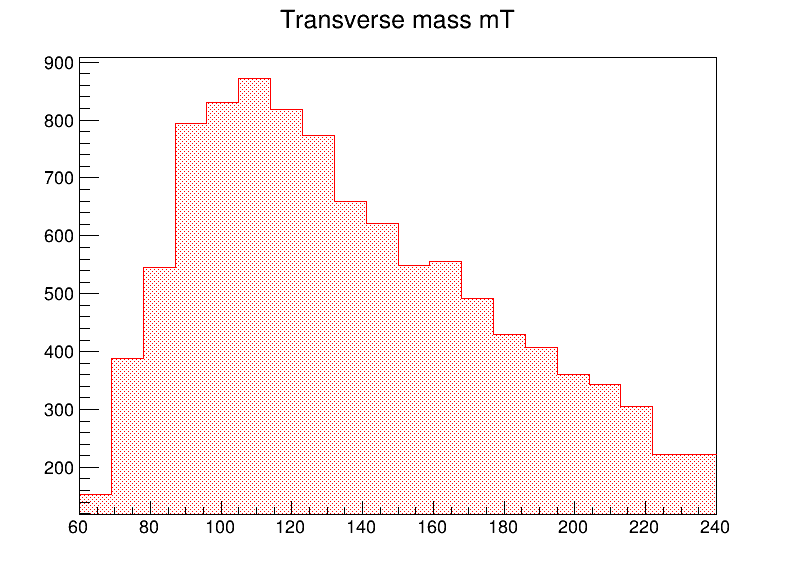

In [41]:
h_dat.SetFillStyle(3003)
h_dat.SetFillColor(2)
h_dat.SetLineColor(2)

h_dat.Draw("hist")
c.Draw()

In [42]:
#MC 
hWW(bkgTree,h_bgs)

Event loop tracker
------------------
0 events processed
100000 events processed
200000 events processed
300000 events processed
400000 events processed
500000 events processed
600000 events processed
700000 events processed
800000 events processed
900000 events processed
1000000 events processed
1100000 events processed
1200000 events processed
1300000 events processed
1400000 events processed
1500000 events processed
1600000 events processed
1700000 events processed
1800000 events processed
1900000 events processed
2000000 events processed
2100000 events processed
2200000 events processed
2300000 events processed
2400000 events processed
2500000 events processed
2600000 events processed
2700000 events processed
2800000 events processed
2900000 events processed
3000000 events processed
3100000 events processed
3200000 events processed
3300000 events processed
3400000 events processed


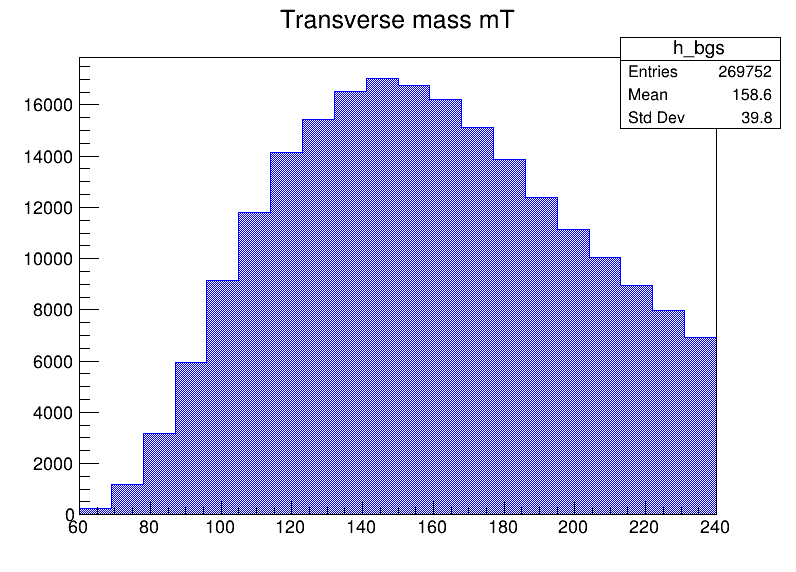

In [14]:
h_bgs.SetFillStyle(3001)
h_bgs.SetFillColor(4)
h_bgs.SetLineColor(4)

h_bgs.Draw("hist")
c.Draw()

---

In [34]:
#MC "lumi weight"
#tree.weight_mc*tree.weight_pileup*tree.weight_leptonSF*tree.weight_jvt*tree['weight_bTagSF_%s'%bTagger]
runCell = True #NB that this cell is only run once! Failsafe flag

if runCell:
    #Calculate lumi weight
    mcScale = 0.04*dataTree.GetEntries()/(bkgTree.GetEntries())
    print('MC event weight = %0.4f' % mcScale)

    #Scale MC histogram
    h_bgs_scale = h_bgs.Clone("scale")
    h_bgs_scale.Scale(mcScale)

MC event weight = 0.0078


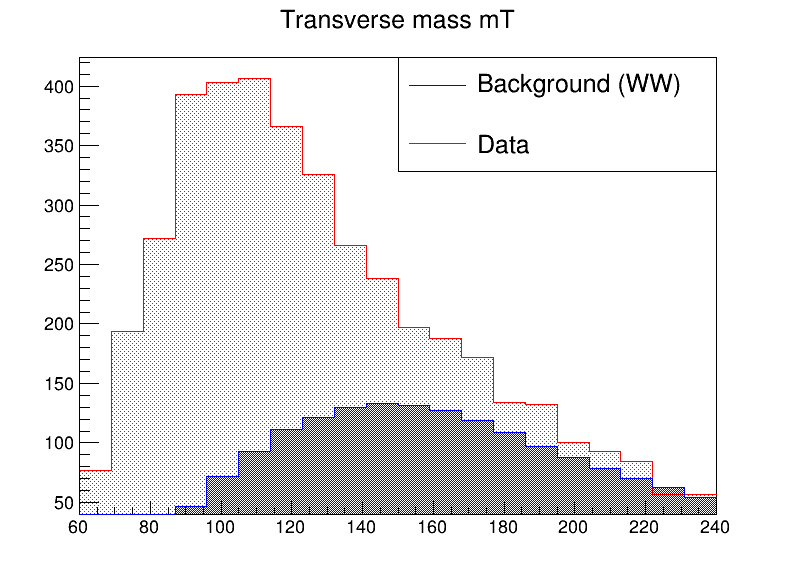

In [35]:
h_dat.Draw("hist")
h_bgs_scale.Draw("histsame")

h_dat.SetStats(0)
h_bgs_scale.SetStats(0)

legend=ROOT.TLegend(0.5,0.7,0.9,0.9)
legend.AddEntry(h_bgs_scale,"Background (WW) ","l")
legend.AddEntry(h_dat,"Data","l")
legend.Draw()

c.Draw()

In [37]:
h_diff = h_dat.Clone("diff")
h_diff.Add(h_bgs_scale,-1)

True

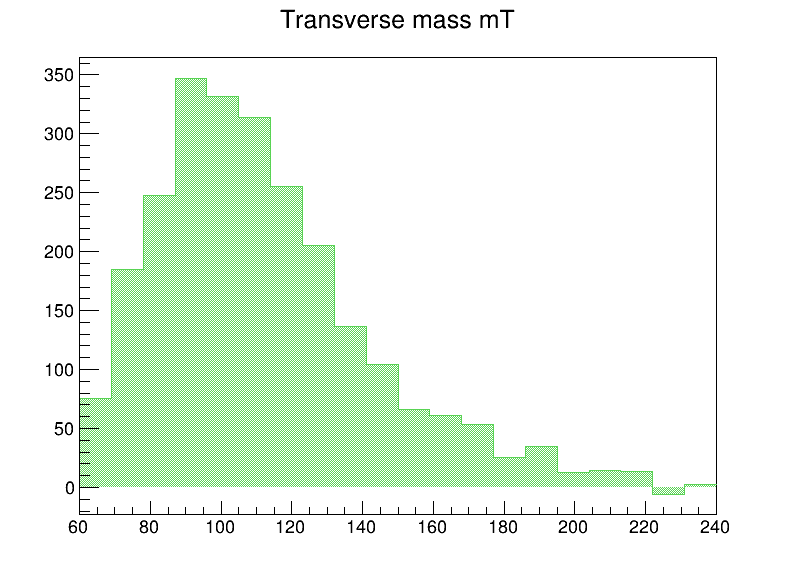

In [38]:
h_diff.SetFillStyle(3001)
h_diff.SetFillColor(8)
h_diff.SetLineColor(8)
h_diff.SetStats(0)
#h_diff.SetMinimum(10)  #This is doing a lot of heavy lifting to hide the data underestimation!

h_diff.Draw("hist")
c.Draw()

1. Background subtracted plot (ratio panel style?)
2. Discovery significance?

In [65]:
###########################
### Plot formatting example
###########################

scale_bgs = h_bgs.Integral()
h_bgs.Scale(1/scale_bgs)

scale_sig = h_sig.Integral()
h_sig.Scale(1/scale_sig)


h_bgs.SetFillStyle(3001)
h_bgs.SetFillColor(4)
h_bgs.SetLineColor(4)

h_sig.SetFillStyle(3003)
h_sig.SetFillColor(2)
h_sig.SetLineColor(2)

legend=ROOT.TLegend(0.5,0.7,0.9,0.9)
legend.AddEntry(h_bgs,"Background (WW) ","l")
legend.AddEntry(h_sig,"Signal (H #rightarrow WW)","l")

h_sig.SetStats(0)
h_bgs.SetStats(0)

h_sig.Draw("hist")
h_bgs.Draw("histsame")
legend.Draw()
c.Draw()


### Follow-up excercises

1. Adding more data will improve the precision of our measurement: dataB-D in same folder
2. Next leading background is top, identified by bjets, which themselves are identified by the `jet` `MV2c10` algorithm. Add a bjet veto to cutflow.

---